<a href="https://colab.research.google.com/github/yaobviously/DFSProjections/blob/master/nbamodelpointsprojection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [573]:
!pip install category_encoders --quiet
!pip install shap --quiet

In [574]:
thisyear = '/content/drive/MyDrive/NBA Player Box Scores/boxscoresmay1.csv'
lastyear = '/content/drive/MyDrive/NBA Player Box Scores/lastseasonclean.csv'

teamvegasly = '/content/drive/MyDrive/NBA Player Box Scores/teamstatslastyear.csv'

In [575]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from xgboost import plot_importance


url = 'https://raw.githubusercontent.com/yaobviously/DFSProjections/main/cleanedbox.csv'
lastseason = 'https://raw.githubusercontent.com/yaobviously/DFSProjections/main/lastseasonclean.csv'
# slate = pd.read_csv('/content/draftkings_NBA_2021-04-26_players.csv')

In [576]:
def wrangle(url):
    
    
    df = pd.read_csv(url,
                     parse_dates = ['DATE'],
                     index_col = 'DATE')
    
    df = df.rename(columns={'BIGDATABALL\nDATASET' : 'game_type',
                            'GAME-ID' : 'gameid',                            
                            'PLAYER-ID' : 'playerid',
                            'PLAYER \nFULL NAME' : 'player',
                            'POSITION' : 'position',
                            'OWN \nTEAM' : 'team', 
                            'OPPONENT \nTEAM' : 'opponent',
                            'VENUE\n(R/H)' : 'venue',
                            'STARTER\n(Y/N)' : 'starter',
                            'USAGE \nRATE (%)' : 'usage',
                            'DAYS\nREST' : 'rest',
                            'TOT' : 'totreb'})
    
    df.columns = df.columns.str.lower()
    
    df['starter'] = [1 if start == 'Y' else 0 for start in df['starter']]
    df['venue'] = df.venue.map({'H' : 1, 'R' : 0})
    df['month'] = pd.DatetimeIndex(df.index).month

    # computing bonus points for double-doubles and triple-doubles
    
    df['dbl_digits'] = (df[['pts', 'a', 'totreb', 'st', 'bl']] >= 10).astype(int).sum(axis=1)    
    df['bonus'] = 0
    df['bonus'].loc[df['dbl_digits'] == 2] = 1.5    
    df['bonus'].loc[df['dbl_digits'] == 3] = 4.5
    
    # computing player fantasy points and game rate
    df['playerfp'] = (df['pts'] + \
                      df['a'] * 1.5 + \
                      df['totreb'] * 1.25 + \
                      df['st'] * 2 + \
                      df['bl'] * 2 + \
                      df['3p'] * 0.5 + \
                      df['to'] * -0.5 + \
                      df['bonus']
                      )
    df['gamefp36'] = ((df['playerfp'] / df['min']) * 36).round(1)
    
    # computing rolling team fantasy points
    
    df['teamfp'] = df.groupby(['gameid', 'team'])['playerfp'].transform(sum)
    
    tm21 = df.groupby(['gameid', 'team'], as_index = False).agg(teamfp = ('playerfp', 'sum'),
                                                                teammin = ('min', 'sum')).drop_duplicates()

    opp21 = df.groupby(['gameid', 'opponent'], as_index = False).agg(oppfp = ('playerfp', 'sum'),
                                                                     oppmin = ('min', 'sum')).drop_duplicates()

    tm21['totteamfp'] = tm21.groupby('team')['teamfp'].transform(lambda x: x.expanding().sum().shift())
    tm21['totteammin'] = tm21.groupby('team')['teammin'].transform(lambda x: x.expanding().sum().shift())
    tm21['fp48'] = (tm21['totteamfp'] / tm21['totteammin']) * 240
    tmdf = tm21[['gameid', 'team', 'fp48']].copy()

    df = df.reset_index().merge(tmdf, how = 'left', on = ['gameid', 'team']).set_index('DATE')

    # computing rolling defense stats

    opp21 = df.groupby(['gameid', 'opponent'], as_index = False).agg(opponent_fp = ('playerfp', 'sum'),
                                                                 opponent_min = ('min', 'sum'))

    opp21['totoppfp'] = opp21.groupby('opponent')['opponent_fp'].transform(lambda x: x.expanding().sum().shift())
    opp21['totoppmin'] = opp21.groupby('opponent')['opponent_min'].transform(lambda x: x.expanding().sum().shift())
    opp21['oppfp48'] = (opp21['totoppfp'] / opp21['totoppmin']) * 240
    oppdf = opp21[['gameid', 'opponent', 'oppfp48']]

    df = df.reset_index().merge(oppdf, how = 'left', on = ['gameid', 'opponent']).set_index('DATE')
    
    # computing running and rolling averages for players

    df['gamesplayed'] = df.groupby('player')['gameid'].cumcount().shift()
    df['avgfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.expanding().mean().shift())
    df['avgfga'] = df.groupby('player')['fga'].transform(lambda x: x.expanding().mean().shift())   
    df['totmin'] = df.groupby('player')['min'].transform(lambda x: x.cumsum().shift())
    df['totfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.cumsum().shift())
    df['seasonfppm'] = (df['totfp'] / df['totmin']).round(2)
    df['ptsseason'] = df.groupby('player')['pts'].transform(lambda x: x.expanding().sum().shift())
    df['ftaseas'] = df.groupby('player')['fta'].transform(lambda x: x.expanding().sum().shift())
    df['fgaseas'] = df.groupby('player')['fga'].transform(lambda x: x.expanding().sum().shift())
    df['3paseas'] = df.groupby('player')['3pa'].transform(lambda x: x.expanding().sum().shift())
    df['3fraction'] = df['3paseas']/df['fgaseas']
    df['starter_avg'] = df.groupby('player')['starter'].transform(lambda x: x.expanding().mean().shift())
    df['starter_diff'] = df['starter'] - df['starter_avg']
    
    df['ts_season'] = (df['ptsseason'] / (2 * (df['fgaseas'] + (df['ftaseas'] * 0.44)))).round(3)
    
    df['mpg'] = df.groupby('player')['min'].transform(lambda x: x.expanding().mean().shift())
    df['rollingmpg'] = df.groupby('player')['min'].transform(lambda x:
                                                             x.rolling(3, min_periods = 1)
                                                             .mean()
                                                             .shift())
    
    df['avgusage'] = df.groupby('player')['usage'].transform(lambda x:
                                                             x.expanding()
                                                             .mean()
                                                             .shift())
    
    df['rollingusage'] = df.groupby('player')['usage'].transform(lambda x:
                                                                 x.rolling(5)
                                                                 .mean()
                                                                 .shift())  
    
    df['stdgamefp'] = df.groupby('player')['gamefp36'].transform(lambda x:
                                                                 x.expanding()
                                                                 .std()
                                                                 .shift())  
    
    df['maxfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.expanding().max().shift())
    df['rollingmaxfp'] = df.groupby('player')['playerfp'].transform(lambda x: x.rolling(5).max().shift())
    df['maxmin'] = df.groupby('player')['min'].transform(lambda x: x.rolling(8).max().shift())
    df['minmin'] = df.groupby('player')['min'].transform(lambda x: x.rolling(8).min().shift())    
    df['extramins'] = df['rollingmpg'] - df['mpg']
    df['extrausage'] = df['rollingusage'] - df['avgusage']
    df['league3p'] = df['3p'].expanding().sum().shift()
    df['league3pa'] = df['3pa'].expanding().sum().shift()
    df['league3perc'] = (df['league3p'] / df['league3pa']).round(3)
    
    df['starter_avg'] = df.groupby('player')['starter'].transform(lambda x: x.expanding().mean().shift())
    df['starter_diff'] = df['starter'] - df['starter_avg']
    df['did_boom'] = (df['playerfp'] >= (df['avgfp'] + 8)).astype(int)
    df['above_avg'] = (df['playerfp'] > df['avgfp']).astype(int)

    # calculating starter stats
    df['gamestartersum'] = df.groupby(['gameid', 'team', 'starter'])['starter_avg'].transform(sum)
    df['starterfpgame'] = df.groupby(['gameid', 'team', 'starter'])['avgfp'].transform(sum)
    
    # dropping colums i don't need 
    
    col_drop = ['dbl_digits', 'playerid', 'ptsseason', 'ftaseas','fgaseas',
                'league3p', 'league3pa', '3paseas']   

    df.drop(col_drop, axis = 1, inplace = True)
    
    return df

In [577]:
df = wrangle(thisyear)

In [578]:

game_stats = ['min', 'fg', 'fga', '3p', '3pa', 'ft', 'fta', 'or', 'dr',
              'totreb', 'a', 'pf', 'st', 'to', 'bl', 'pts', 'usage',
              'bonus', 'teamfp', 'gameid', 'game_type',
              'gamefp36', 'above_avg', 'playerfp']


model_cols = ['avgfp', 'starter', 'extramins', 'rollingmaxfp', 'starter_diff',
            'seasonfppm', 'starterfpgame', 'oppfp48', 'playerfp', 'stdgamefp']

df_model = df[model_cols]

In [579]:
# In this cell we specify the target and divide the data set into the train and
# test sets using a date threshold

target = 'playerfp'

date_threshold = '2021-02-28'
mask = df_model.index < date_threshold

X = df_model.drop(target, axis = 1)
y = df_model[target]

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

In [580]:
baseline = mean_squared_error(y_test, X_test['avgfp'].fillna(method = 'bfill'))

print('The mean squared error using only the average fp to date is:', baseline)

The mean squared error using only the average fp to date is: 97.74029633745856


In [582]:
model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    XGBRegressor(eval_metric = 'rmse',
                 n_estimators = 100,
                 max_depth = 3)
)

model_xg.fit(X_train, y_train);

[03:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [585]:
depths = [n for n in np.arange(1,6, 1)]
train = []
test = []

for d in depths:
  model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    XGBRegressor(eval_metric = 'rmse',
                 n_estimators = 100,
                 max_depth = d)
  )

  model_xg.fit(X_train, y_train)
  train_ = mean_squared_error(y_train, model_xg.predict(X_train))
  test_ = mean_squared_error(y_test, model_xg.predict(X_test))
  train.append(train_)
  test.append(test_)

[03:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:51:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
encoder = OrdinalEncoder()
imputer = SimpleImputer()
booster = XGBRegressor(eval_metric = 'rmse',
                        n_estimators = 100,
                        learning_rate = 0.1)

X_test_encoded = encoder.fit_transform(X_test)
X_test_imputed = imputer.fit_transform(X_test_encoded)
X_imp_df = pd.DataFrame(X_test_imputed, columns = X_test.columns)

booster.fit(X_test_imputed, y_test)

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test_imputed)

[03:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


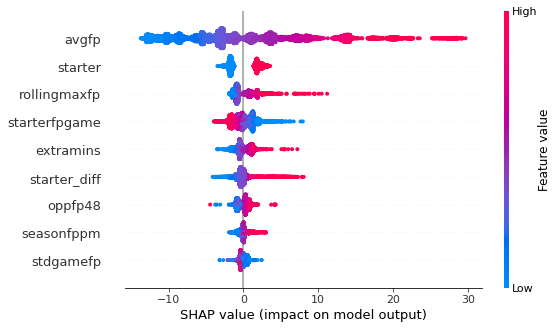

In [ ]:
shap.summary_plot(shap_values,
                  X_imp_df,
                  )


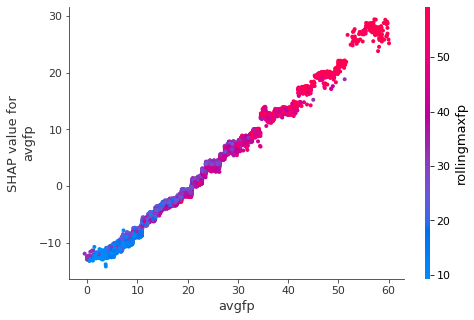

In [ ]:
shap.dependence_plot('avgfp',
                     shap_values,
                     X_imp_df)

In [ ]:
mean_squared_error(y_test, model_xg.predict(X_test))

86.47824906144722